Should we calculate difference? https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

Convert wind dirs to degrees for numerical values? https://study.com/cimages/multimages/16/cb_1_copy.jpeg
    - No: convert to direction vector: https://www.tensorflow.org/tutorials/structured_data/time_series
    
Major issue to resolve - data is not strictly time series as it contains the data from many sites over time, with overlapping time frames. How to prevent model from considering one site's time series data as an extension of the previous site's?

In [222]:
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

# data = pd.read_csv('../training_data/training_set.csv')
data = pd.read_csv('../weatherAUS.csv')

In [223]:
# this does not really work accurately
locs = pd.read_csv('locations.csv')
bbox = (89.868, 176.001, 2.592, -47.309)
# bbox = (locs.lon.min(), locs.lon.max(), locs.lat.min(), locs.lat.max())

m = plt.imread('map.png')

fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(locs.lon, locs.lat, zorder=1, alpha=0.2, c='b', s=10)
ax.set_xlim(bbox[0], bbox[1])
ax.set_ylim(bbox[2], bbox[3])
ax.invert_yaxis()
ax.imshow(m, zorder=0, extent=bbox, aspect='equal', origin='lower')

locs.lon.min(), locs.lon.max(), locs.lat.min(), locs.lat.max()

FileNotFoundError: [Errno 2] No such file or directory: 'locations.csv'

In [ ]:
data['Location'].value_counts()

In [221]:
(data.isna().sum() / data.shape[0]) * 100 # what percent of each column is NA?
data["RainTomorrow"].value_counts() # our data is not balanced between classes

Date              0.000000
Location          0.000000
MinTemp           0.447983
MaxTemp           0.226453
Rainfall          0.988797
Evaporation      42.789026
Sunshine         47.692924
WindGustDir       6.561504
WindGustSpeed     6.519308
WindDir9am        7.041838
WindDir3pm        2.656952
WindSpeed9am      0.948007
WindSpeed3pm      1.849599
Humidity9am       1.247600
Humidity3pm       2.538803
Pressure9am       9.855619
Pressure3pm       9.832411
Cloud9am         37.735332
Cloud3pm         40.152469
Temp9am           0.635756
Temp3pm           1.917113
RainToday         0.988797
RISK_MM           0.000000
RainTomorrow      0.000000
dtype: float64

In [224]:
# convert to binary
data["RainTomorrow"].replace(('Yes', 'No'), (1, 0), inplace=True)
data["RainToday"].replace(('Yes', 'No'), (1, 0), inplace=True)
data.drop(columns=['Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'RISK_MM'], inplace=True)

# convert direction strings to degrees
data['WindGustDir'].replace(
    ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
    (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
    inplace=True
)

data['WindDir9am'].replace(
    ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
    (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
    inplace=True
)

data['WindDir3pm'].replace(
    ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
    (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
    inplace=True
)

In [225]:
# drop na in listed columns
data.dropna(
    axis=0, how='any',
    subset=['WindGustDir','WindDir9am','WindDir3pm','WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'],
    inplace=True
)

data.dropna(axis=0, how='any', inplace=True)

data_date = pd.to_datetime(data.pop('Date'))

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

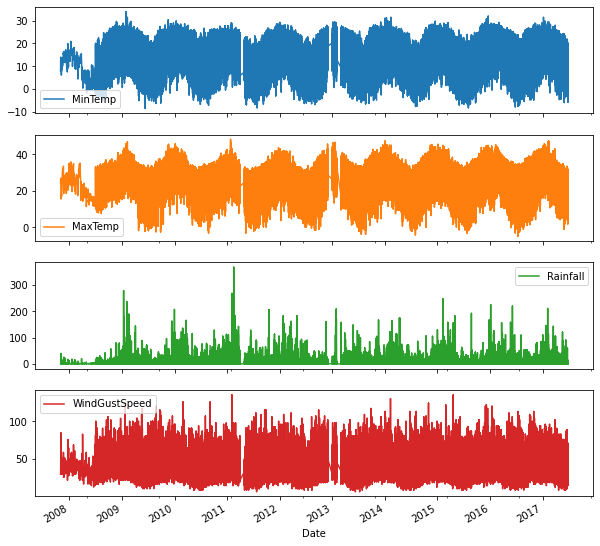

In [212]:
# plot features over time
plot_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed']
# plot_cols = ['Rainfall']
plot_features = data[plot_cols]
plot_features.index = data_date
plot_features.plot(subplots=True, figsize=(10,10))

In [213]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MinTemp,124528.0,12.417752,6.364824,-8.5,7.8,12.2,17.1,33.9
MaxTemp,124620.0,23.472416,7.201660,-4.8,18.1,23.0,28.6,48.1
Rainfall,123710.0,2.375661,8.528039,0.0,0.0,0.0,0.8,367.6
WindGustDir,124668.0,170.061543,100.374910,0.0,90.0,180.0,247.5,337.5
WindGustSpeed,124668.0,40.695263,13.397250,7.0,31.0,39.0,48.0,135.0
WindDir9am,124668.0,162.105833,104.636639,0.0,67.5,157.5,247.5,337.5
WindDir3pm,124668.0,172.020286,100.846253,0.0,90.0,180.0,270.0,337.5
WindSpeed9am,124668.0,15.022123,8.315155,2.0,9.0,13.0,20.0,87.0
WindSpeed3pm,124668.0,19.180993,8.575571,2.0,13.0,19.0,24.0,87.0
Humidity9am,123636.0,67.673906,19.040380,0.0,56.0,69.0,82.0,100.0


Text(0, 0.5, 'Wind Velocity [m/s]')

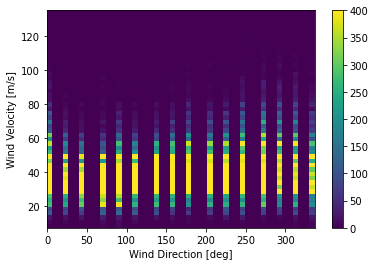

In [214]:
# plot distribution of wind data
plt.hist2d(data['WindGustDir'], data['WindGustSpeed'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [226]:
# convert all wind data to vectors
wv = data.pop('WindGustSpeed')
wd = data.pop('WindGustDir')*np.pi/180
data['WindGustX'] = wv*np.cos(wd)
data['WindGustY'] = wv*np.sin(wd)

wv = data.pop('WindSpeed9am')
wd = data.pop('WindDir9am')*np.pi/180
data['Wind9amX'] = wv*np.cos(wd)
data['Wind9amY'] = wv*np.sin(wd)

wv = data.pop('WindSpeed3pm')
wd = data.pop('WindDir3pm')*np.pi/180
data['Wind3pmX'] = wv*np.cos(wd)
data['Wind3pmY'] = wv*np.sin(wd)

(-135.0, 107.0, -126.0, 104.0)

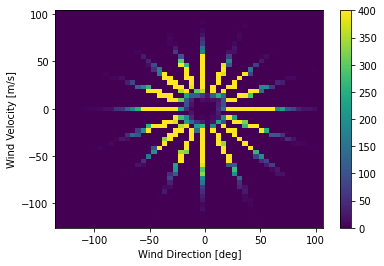

In [227]:
# plot distribution of new wind vectors
plt.hist2d(data['WindGustX'], data['WindGustY'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
ax = plt.gca()
ax.axis('tight')

In [228]:
timestamp_s = data_date.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day
data['daysin'] = np.sin(timestamp_s * (2 * np.pi/day))
data['daycos'] = np.cos(timestamp_s * (2 * np.pi/day))
data['yearsin'] = np.sin(timestamp_s * (2 * np.pi/year))
data['yearcos'] = np.cos(timestamp_s * (2 * np.pi/year))

In [229]:
# split and normalize all the data
n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]

cols_to_norm = list(data.columns)
cols_to_norm.remove('RainToday')
cols_to_norm.remove('RainTomorrow')

train_mean = train_df[cols_to_norm].mean()
train_std = train_df[cols_to_norm].std()

train_df.loc[:,cols_to_norm] = (train_df.loc[:,cols_to_norm] - train_mean) / train_std
val_df.loc[:,cols_to_norm] = (val_df.loc[:,cols_to_norm] - train_mean) / train_std
test_df.loc[:,cols_to_norm] = (test_df.loc[:,cols_to_norm] - train_mean) / train_std

/home/mqp/pyenv/lib/python3.7/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


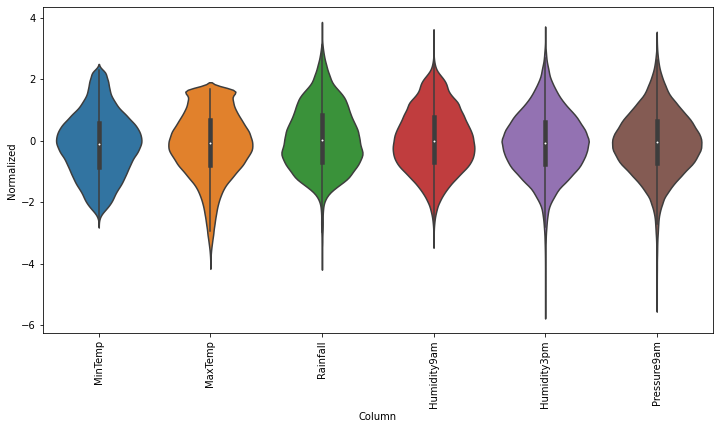

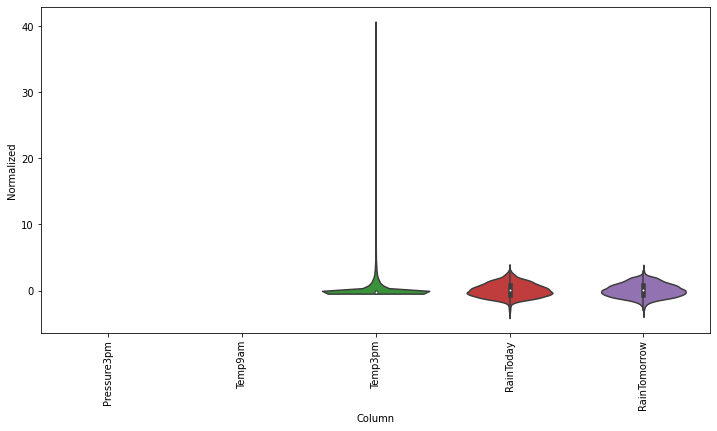

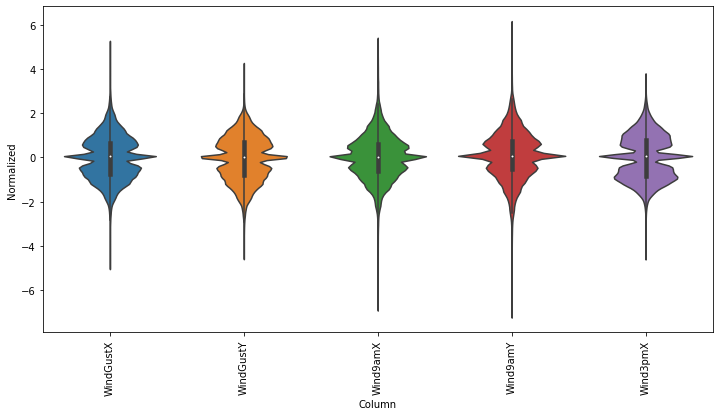

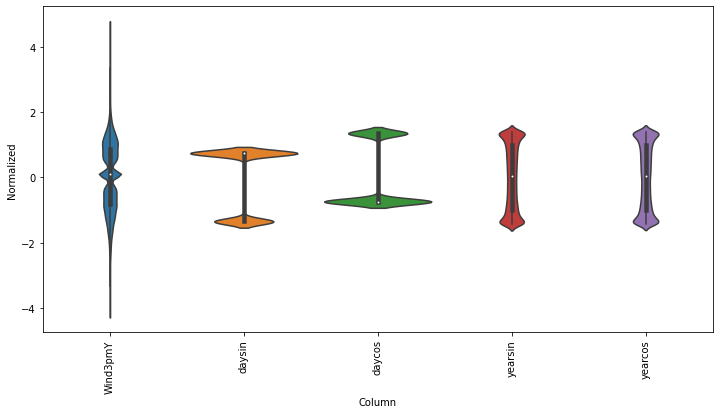

In [219]:
data_std = (data - train_mean) / train_std
data_melted = data_std.melt(var_name='Column', value_name='Normalized')
var_rows = int(data_melted.shape[0]/21) # number of rows for each variable

plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_melted[:var_rows*6])
_ = ax.set_xticklabels(data.keys()[:6], rotation=90)

plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_melted[var_rows*6:var_rows*11])
_ = ax.set_xticklabels(data.keys()[6:11], rotation=90)

plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_melted[var_rows*11:var_rows*16])
_ = ax.set_xticklabels(data.keys()[11:16], rotation=90)

plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_melted[var_rows*16:var_rows*21])
_ = ax.set_xticklabels(data.keys()[16:21], rotation=90)

In [230]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#1_indexes_and_offsets
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None, batch_size=32):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='RainTomorrow', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        predictions = 0
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=batch_size,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [231]:
from sklearn.metrics import confusion_matrix, f1_score
def visual_cm(y_train, y_pred):
    cm = confusion_matrix(y_train, y_pred,labels = [1,0])
    group_names = ['TP','FN','FP','TN']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = [1,0], yticklabels = ['Rain','No Rain'])
    
    sensitivity = "{0:.2%}".format(cm[0,0]/(cm[0,0]+cm[0,1]))
    specificity = "{0:.2%}".format(cm[1,1]/(cm[1,0]+cm[1,1]))
    print("Sensitivity(ability to detect rain in rainy days):", sensitivity)
    print("Specificity(ability to detect Not rain in normal days):",specificity)
    print("f1 score:", f1_score(y_train, y_pred))    

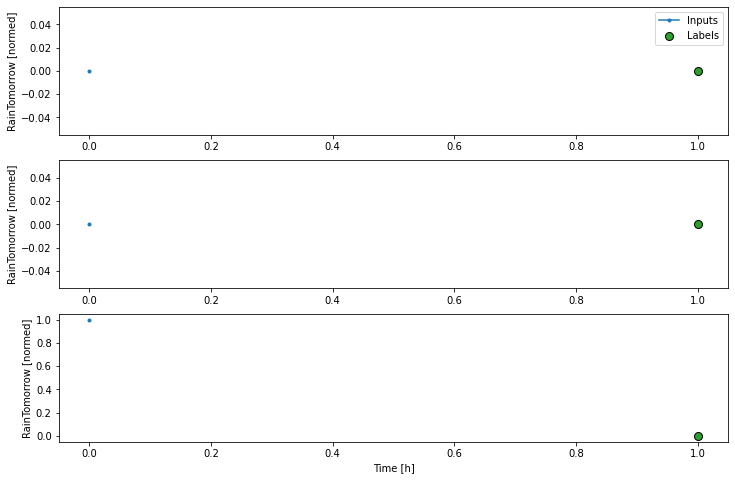

In [232]:
batch_size=32
w = WindowGenerator(input_width = 1, label_width=1, shift=1, label_columns=['RainTomorrow'])
w.plot()

In [ ]:
for example_inputs, example_labels in w.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [233]:
w = WindowGenerator(input_width = 7, label_width=1, shift=1, label_columns=['RainTomorrow'])
# w.train
w.val

<MapDataset shapes: ((None, 7, 21), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [234]:
epochs = 20

linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

val_performance = {}
performance = {}

def compile_and_fit(model, window, lr=0.001, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(loss=tf.losses.BinaryCrossentropy(), optimizer=tf.optimizers.Adam(lr=lr),
        metrics=[tf.metrics.BinaryAccuracy()])
#     model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(),
#         metrics=[tf.metrics.MeanAbsoluteError()])
    
#     model.compile(loss='binary_crossentropy', optimizer='adam')
    
    history = model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=[early_stopping])
    return history    

In [ ]:
history = compile_and_fit(linear_model, w)

val_performance['Linear'] = linear_model.evaluate(w.val)
performance['Linear'] = linear_model.evaluate(w.test, verbose=0)

In [ ]:
dense_model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')
])

history = compile_and_fit(dense_model, w)
val_performance['Dense'] = dense_model.evaluate(w.val)
performance['Dense'] = dense_model.evaluate(w.test, verbose=0)

In [35]:
# preds = w.plot(dense_model)
# print(preds)

preds = dense_model.predict_classes(w.test_df)


In [36]:
tmp = w.train_df.reset_index()['RainTomorrow']
count = 0

# for i in range(100,200):
#     print(preds[i][0])

for i in range(1,preds.shape[0]):
# for i in range(100,200):
#     print(preds[i][0])
#     print(tmp[i])
    if ((preds[i][0]-tmp[i])**2) == 0:
        count+=1
print((preds[1][0] - tmp[1])^2)  
count/preds.shape[0]

2


0.7551957744861637

In [ ]:
w = WindowGenerator(input_width = 7, label_width=1, shift=1, label_columns=['RainTomorrow'])
multi_dense_model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
    keras.layers.Reshape([1, -1])
])

history = compile_and_fit(multi_dense_model, w)
val_performance['Multi step dense'] = multi_dense_model.evaluate(w.val)
performance['Multi step dense'] = multi_dense_model.evaluate(w.test, verbose=0)

In [235]:
c_width = 7
w = WindowGenerator(input_width = c_width, label_width=1, shift=1, label_columns=['RainTomorrow'])
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=c_width, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

history = compile_and_fit(cnn_model, w)
val_performance['Conv'] = cnn_model.evaluate(w.val)

w.plot(cnn_model)
inputs = w.train
preds = cnn_model(inputs)
preds

Epoch 1/20
2470/2470 [==============================] - 22s 9ms/step - loss: 0.4875 - binary_accuracy: 0.7739 - val_loss: 0.4405 - val_binary_accuracy: 0.8004
Epoch 2/20
2470/2470 [==============================] - 19s 8ms/step - loss: 0.4690 - binary_accuracy: 0.7812 - val_loss: 0.4323 - val_binary_accuracy: 0.8056
Epoch 3/20
 350/2470 [===>..........................] - ETA: 16s - loss: 0.4639 - binary_accuracy: 0.7832

KeyboardInterrupt: 

In [ ]:


--------------------------------------



In [166]:
n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):]
test_df = data[int(n*0.9):2000]

cols_to_norm = list(data.columns)
cols_to_norm.remove('RainToday')
cols_to_norm.remove('RainTomorrow')

train_mean = train_df[cols_to_norm].mean()
train_std = train_df[cols_to_norm].std()

train_df.loc[:,cols_to_norm] = (train_df.loc[:,cols_to_norm] - train_mean) / train_std
val_df.loc[:,cols_to_norm] = (val_df.loc[:,cols_to_norm] - train_mean) / train_std
test_df.loc[:,cols_to_norm] = (test_df.loc[:,cols_to_norm] - train_mean) / train_std

In [ ]:
epochs = 10
lr=0.00001
batch_size = 32

w = WindowGenerator(input_width=7, label_width=1, shift=1, train_df = train_df, val_df=val_df, label_columns=['RainTomorrow'])
lstm_model = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(16, return_sequences=True),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.LSTM(32, return_sequences=True),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.LSTM(64, return_sequences=True),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4, return_sequences=False)),
#     tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Reshape([1, -1])
    
])

print('Input shape:', w.example[0].shape)
print('Output shape:', lstm_model(w.example[0]).shape)


history = compile_and_fit(lstm_model, w, lr=lr)
val_performance['lstm_model'] = lstm_model.evaluate(w.val)
performance['lstm_model'] = lstm_model.evaluate(w.test, verbose=0)


0    1156
1     837
Name: 0, dtype: int64
(1993,)
(1993,)
0.5469141996989463
Sensitivity(ability to detect rain in rainy days): 40.83%
Specificity(ability to detect Not rain in normal days): 57.75%
f1 score: 0.24561403508771926


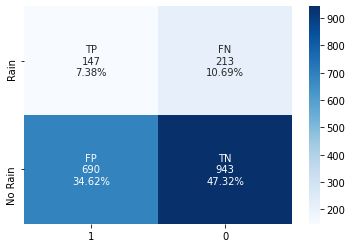

In [165]:
preds = lstm_model.predict(w.val)
count = 0
ytrue = np.array(w.val_df[7:]['RainTomorrow'])

preds = preds.reshape(preds.shape[0])
preds = np.array([(x>0.5).astype("int32") for x in preds])

print(pd.DataFrame(preds)[0].value_counts())
print(preds.shape)
print(ytrue.shape)


for i in range(0,preds.shape[0]):
    if ((preds[i]-ytrue[i])**2) == 0:
        count+=1
print(count/preds.shape[0])

visual_cm(ytrue, preds)

In [150]:
preds = lstm_model.predict(w.val)
# preds.shape
# w.val_df.shape

In [164]:
# 5 epoch results
count = 0
ytrue = np.array(w.val_df[14:]['RainTomorrow'])

preds = preds.reshape(preds.shape[0])
preds = np.array([(x>0.5).astype("int32") for x in preds])

print(pd.DataFrame(preds)[0].value_counts())
print(preds.shape)
print(ytrue.shape)


for i in range(0,preds.shape[0]):
    if ((preds[i]-ytrue[i])**2) == 0:
        count+=1
print(count/preds.shape[0])

visual_cm(ytrue, preds)

0    1156
1     837
Name: 0, dtype: int64
(1993,)
(1986,)


IndexError: index 1986 is out of bounds for axis 0 with size 1986

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

history.history